<a href="https://colab.research.google.com/github/Santiago-Echeverri-Arteaga/Fisica_Computacional_2/blob/master/Transfer_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OJO: IMPORTAR TORCH Y REVISAR LA SALIDA DE torch.cuda.is_available() SI LA SALIDA ES FLASE **NO** EJECUTAR ESTE CÓDIGO!!!

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/Colab Notebooks/alien_pred"
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'validation']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 694, 'validation': 200}


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


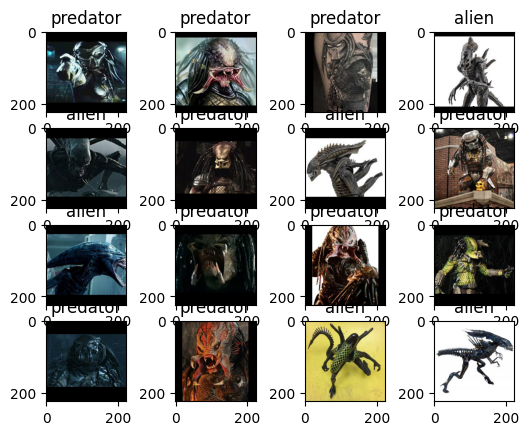

In [ ]:
images, labels = next(iter(dataloaders['train']))

rows = 4
columns = 4
fig=plt.figure()
for i in range(16):
   fig.add_subplot(rows, columns, i+1)
   plt.title(class_names[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = std * img + mean
   plt.imshow(img)
plt.show()

In [ ]:
## Load the model based on VGG19
vgg_based = torchvision.models.vgg19(pretrained=True)

## freeze the layers
for param in vgg_based.parameters():
   param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(class_names))])
vgg_based.classifier = torch.nn.Sequential(*features)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 104MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       # model.train()

       train_loss = 0

       # Iterate over data.
       for i, data in enumerate(dataloaders['train']):
           inputs , labels = data
           inputs = inputs.to(device)
           labels = labels.to(device)

           optimizer.zero_grad()
          
           with torch.set_grad_enabled(True):
               outputs  = model(inputs)
               loss = criterion(outputs, labels)

           loss.backward()
           optimizer.step()

           train_loss += loss.item() * inputs.size(0)

           print('{} Loss: {:.4f}'.format(
               'train', train_loss / dataset_sizes['train']))
          
   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

   return model

def visualize_model(model, num_images=6):
   was_training = model.training
   model.eval()
   images_so_far = 0
   fig = plt.figure()

   with torch.no_grad():
       for i, (inputs, labels) in enumerate(dataloaders['validation']):
           inputs = inputs.to(device)
           labels = labels.to(device)

           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)

           for j in range(inputs.size()[0]):
               images_so_far += 1
               ax = plt.subplot(num_images//2, 2, images_so_far)
               ax.axis('off')
               ax.set_title('predicted: {} truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
               img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
               img = std * img + mean
               ax.imshow(img)

               if images_so_far == num_images:
                   model.train(mode=was_training)
                   return
       model.train(mode=was_training)

Epoch 0/24
----------
train Loss: 0.0349
train Loss: 0.0678
train Loss: 0.0988
train Loss: 0.1220
train Loss: 0.1505
train Loss: 0.1799
train Loss: 0.2034
train Loss: 0.2268
train Loss: 0.2494
train Loss: 0.2702
train Loss: 0.2899
train Loss: 0.3103
train Loss: 0.3323
train Loss: 0.3485
train Loss: 0.3612
train Loss: 0.3816
train Loss: 0.3955
train Loss: 0.4092
train Loss: 0.4240
train Loss: 0.4380
train Loss: 0.4518
train Loss: 0.4626
Epoch 1/24
----------
train Loss: 0.0139
train Loss: 0.0222
train Loss: 0.0330
train Loss: 0.0479
train Loss: 0.0628
train Loss: 0.0747
train Loss: 0.0974
train Loss: 0.1052
train Loss: 0.1105
train Loss: 0.1210
train Loss: 0.1363
train Loss: 0.1434
train Loss: 0.1495
train Loss: 0.1657
train Loss: 0.1808
train Loss: 0.1884
train Loss: 0.2122
train Loss: 0.2204
train Loss: 0.2347
train Loss: 0.2443
train Loss: 0.2531
train Loss: 0.2576
Epoch 2/24
----------
train Loss: 0.0088
train Loss: 0.0205
train Loss: 0.0285
train Loss: 0.0363
train Loss: 0.0454
tra

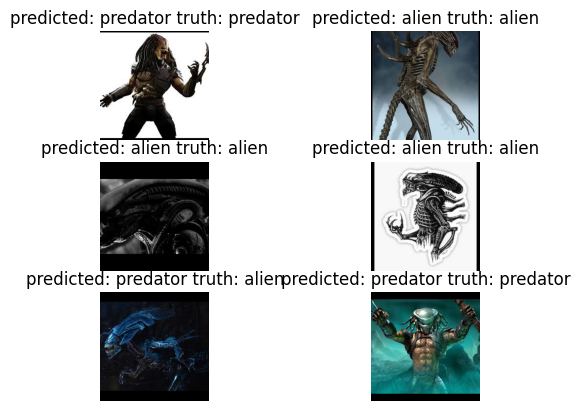

In [ ]:
vgg_based = train_model(vgg_based, criterion, optimizer_ft, num_epochs=25)

visualize_model(vgg_based)

plt.show()

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

In [ ]:
check_accuracy(dataloaders['validation'], vgg_based)

Got 184 / 200 with accuracy 92.00
